In [1]:
import pandas as pd
from sklearn import model_selection
from tensorflow.keras import Model
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, Dropout, Input, Flatten
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt
import joblib

### 1. Data Cleaning

In [2]:
df_raw = pd.read_csv('../two_reactions_022624.csv')
df_raw.tail()

,Unnamed: 0,Temperature,A1,Ea1,A2,Ea2,A3,Ea3,A4,Ea4,...,cINT1_10800s,cINT1_14400s,Fast_rxn1,Medium_rxn1,Slow_rxn1,Fast_rxn2,Medium_rxn2,Slow_rxn2,Reaction_order,Mechanism
1933581,1933581,273,261.472219,194,0.044413,141,0,0,0,0,...,4.236088e-02,3.977472e-02,1,0,0,0,0,1,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(93, 254)"
1933582,1933582,273,596.074861,62,8.957436,9,0,0,0,0,...,9.985276e-06,7.871450e-06,1,0,0,0,1,0,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(93, 254)"
1933583,1933583,273,423.789150,55,904.812139,184,0,0,0,0,...,1.042629e-07,7.955867e-08,1,0,0,1,0,0,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(93, 254)"
1933584,1933584,273,0.014179,123,0.061371,74,0,0,0,0,...,8.618686e-03,8.963359e-03,0,0,1,0,0,1,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(93, 254)"
1933585,1933585,273,0.045442,179,1.544173,121,0,0,0,0,...,2.689157e-03,2.451002e-03,0,0,1,0,1,0,"{'rxn1': {'SM': 2, 'C': 2, 'B': 2, 'R': 2}, 'r...","(93, 254)"


In [3]:
df_raw.shape

(1933586, 258)

In [5]:
y_raw_df = df_raw.iloc[:, -1:]

In [7]:
unique_values = y_raw_df['Mechanism'].unique()
print(len(unique_values))

456


In [8]:
df = df_raw.copy()
df.shape

(1933586, 258)

In [10]:
conc_list = [col for col in df.columns if col.endswith('s')]
# conc_list

In [11]:
x_df_raw = df[conc_list]
x_df_raw.head()

,cSM_0s,cSM_0.1s,cSM_1s,cSM_20s,cSM_40s,cSM_60s,cSM_120s,cSM_180s,cSM_240s,cSM_300s,...,cINT1_2400s,cINT1_3000s,cINT1_3600s,cINT1_4500s,cINT1_5400s,cINT1_6300s,cINT1_7200s,cINT1_9000s,cINT1_10800s,cINT1_14400s
0,0.3,0.299999,0.299992,0.299837,0.299675,0.299514,0.299035,0.298564,0.298101,0.297645,...,0.006314,0.006981,0.007418,0.007767,0.007898,0.007860,0.007791,0.007491,0.007172,0.006560
1,0.3,0.300000,0.299999,0.299978,0.299957,0.299935,0.299870,0.299805,0.299740,0.299675,...,0.000503,0.000512,0.000509,0.000498,0.000495,0.000490,0.000485,0.000474,0.000466,0.000450
2,0.3,0.300000,0.299996,0.299926,0.299853,0.299780,0.299561,0.299344,0.299129,0.298914,...,0.000119,0.000117,0.000115,0.000111,0.000108,0.000106,0.000103,0.000099,0.000095,0.000088
3,0.3,0.299989,0.299887,0.297811,0.295775,0.293877,0.288868,0.284657,0.281052,0.277897,...,0.017600,0.016738,0.015892,0.014708,0.013685,0.012807,0.012051,0.010814,0.009851,0.008435
4,0.3,0.299941,0.299417,0.290150,0.282960,0.277360,0.265672,0.257948,0.252221,0.247715,...,0.004310,0.003784,0.003389,0.002952,0.002632,0.002379,0.002182,0.001874,0.001653,0.001348


In [12]:
x_df_raw.shape

(1933586, 240)

In [13]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Transpose the DataFrame so that rows become columns for scaling
x_df_transposed = x_df_raw.T

# Scale the entire transposed DataFrame
scaled_data = scaler.fit_transform(x_df_transposed)

# Transpose the scaled data back to the original orientation
x = pd.DataFrame(scaled_data.T, columns=x_df_raw.columns, index=x_df_raw.index)


In [14]:
x.head()

,cSM_0s,cSM_0.1s,cSM_1s,cSM_20s,cSM_40s,cSM_60s,cSM_120s,cSM_180s,cSM_240s,cSM_300s,...,cINT1_2400s,cINT1_3000s,cINT1_3600s,cINT1_4500s,cINT1_5400s,cINT1_6300s,cINT1_7200s,cINT1_9000s,cINT1_10800s,cINT1_14400s
0,0.333333,0.333332,0.333324,0.333152,0.332972,0.332793,0.332261,0.331738,0.331224,0.330717,...,0.007016,0.007757,0.008242,0.008630,0.008775,0.008734,0.008657,0.008323,0.007969,0.007289
1,0.333333,0.333333,0.333332,0.333309,0.333285,0.333261,0.333189,0.333117,0.333045,0.332973,...,0.000559,0.000569,0.000566,0.000553,0.000549,0.000545,0.000539,0.000527,0.000517,0.000500
2,0.333333,0.333333,0.333329,0.333252,0.333170,0.333089,0.332846,0.332605,0.332365,0.332127,...,0.000133,0.000130,0.000127,0.000124,0.000120,0.000117,0.000115,0.000110,0.000105,0.000098
3,0.333333,0.333321,0.333207,0.330901,0.328639,0.326530,0.320964,0.316285,0.312280,0.308774,...,0.019555,0.018597,0.017658,0.016342,0.015205,0.014230,0.013390,0.012016,0.010945,0.009372
4,0.333333,0.333268,0.332686,0.322389,0.314400,0.308178,0.295191,0.286609,0.280245,0.275239,...,0.004789,0.004205,0.003766,0.003280,0.002925,0.002643,0.002424,0.002082,0.001837,0.001498


In [15]:
x.shape

(1933586, 240)

In [18]:
y_df = df.iloc[:, -1:]
# y_df

In [19]:
y_df_oh = pd.get_dummies(y_df, columns = ['Mechanism']) 
y_df_oh

,"Mechanism_(0, 146)","Mechanism_(0, 147)","Mechanism_(0, 154)","Mechanism_(0, 155)","Mechanism_(1, 146)","Mechanism_(1, 147)","Mechanism_(1, 154)","Mechanism_(1, 155)","Mechanism_(101, 126)","Mechanism_(101, 162)",...,"Mechanism_(97, 128)","Mechanism_(97, 166)","Mechanism_(97, 167)","Mechanism_(97, 181)","Mechanism_(97, 220)","Mechanism_(97, 221)","Mechanism_(97, 338)","Mechanism_(97, 386)","Mechanism_(97, 404)","Mechanism_(97, 452)"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1933581,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1933582,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1933583,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1933584,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [20]:
file_path = 'y_df_oh_NN.h5'
y_df_oh.to_hdf(file_path, key='data', mode='w')

### 2. LSTM Model

#### 2.1 Split Dataset

In [22]:
x.head()

,cSM_0s,cSM_0.1s,cSM_1s,cSM_20s,cSM_40s,cSM_60s,cSM_120s,cSM_180s,cSM_240s,cSM_300s,...,cINT1_2400s,cINT1_3000s,cINT1_3600s,cINT1_4500s,cINT1_5400s,cINT1_6300s,cINT1_7200s,cINT1_9000s,cINT1_10800s,cINT1_14400s
0,0.333333,0.333332,0.333324,0.333152,0.332972,0.332793,0.332261,0.331738,0.331224,0.330717,...,0.007016,0.007757,0.008242,0.008630,0.008775,0.008734,0.008657,0.008323,0.007969,0.007289
1,0.333333,0.333333,0.333332,0.333309,0.333285,0.333261,0.333189,0.333117,0.333045,0.332973,...,0.000559,0.000569,0.000566,0.000553,0.000549,0.000545,0.000539,0.000527,0.000517,0.000500
2,0.333333,0.333333,0.333329,0.333252,0.333170,0.333089,0.332846,0.332605,0.332365,0.332127,...,0.000133,0.000130,0.000127,0.000124,0.000120,0.000117,0.000115,0.000110,0.000105,0.000098
3,0.333333,0.333321,0.333207,0.330901,0.328639,0.326530,0.320964,0.316285,0.312280,0.308774,...,0.019555,0.018597,0.017658,0.016342,0.015205,0.014230,0.013390,0.012016,0.010945,0.009372
4,0.333333,0.333268,0.332686,0.322389,0.314400,0.308178,0.295191,0.286609,0.280245,0.275239,...,0.004789,0.004205,0.003766,0.003280,0.002925,0.002643,0.002424,0.002082,0.001837,0.001498


In [23]:
x.shape

(1933586, 240)

In [24]:
y_df = y_df_oh.copy()
y_df.head()

,"Mechanism_(0, 146)","Mechanism_(0, 147)","Mechanism_(0, 154)","Mechanism_(0, 155)","Mechanism_(1, 146)","Mechanism_(1, 147)","Mechanism_(1, 154)","Mechanism_(1, 155)","Mechanism_(101, 126)","Mechanism_(101, 162)",...,"Mechanism_(97, 128)","Mechanism_(97, 166)","Mechanism_(97, 167)","Mechanism_(97, 181)","Mechanism_(97, 220)","Mechanism_(97, 221)","Mechanism_(97, 338)","Mechanism_(97, 386)","Mechanism_(97, 404)","Mechanism_(97, 452)"
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [25]:
y_df.shape

(1933586, 456)

In [26]:
y = np.where(y_df, 1, 0)
y

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [30]:
x_train_df, x_val_df, y_train, y_val = model_selection.train_test_split(x, y, test_size=0.05, random_state=37)

In [31]:
print('Training set size:  ',x_train_df.shape, y_train.shape)
print('Validation set size:',x_val_df.shape, y_val.shape)

Training set size:   (1836906, 240) (1836906, 456)
Validation set size: (96680, 240) (96680, 456)


In [32]:
x_train_df.head()

,cSM_0s,cSM_0.1s,cSM_1s,cSM_20s,cSM_40s,cSM_60s,cSM_120s,cSM_180s,cSM_240s,cSM_300s,...,cINT1_2400s,cINT1_3000s,cINT1_3600s,cINT1_4500s,cINT1_5400s,cINT1_6300s,cINT1_7200s,cINT1_9000s,cINT1_10800s,cINT1_14400s
1459100,0.666666,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.561708,0.553785,0.547734,0.540914,0.535847,0.531923,0.528790,0.524104,0.520750,0.516260
1896046,0.833333,0.833330,0.833298,0.832626,0.831924,0.831228,0.829172,0.827164,0.825202,0.823285,...,0.000009,0.000009,0.000008,0.000008,0.000008,0.000008,0.000008,0.000007,0.000007,0.000007
968160,0.333333,0.333297,0.332970,0.326250,0.319520,0.313114,0.295610,0.280275,0.266704,0.254590,...,0.069588,0.063861,0.058443,0.051457,0.045791,0.041188,0.037404,0.031587,0.027340,0.021568
605448,0.333333,0.003058,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000006,0.000006,0.000004,0.000003,0.000003,0.000003,0.000002,0.000002,0.000001,0.000001
1574931,0.666667,0.666148,0.661630,0.603996,0.578012,0.563949,0.544214,0.535572,0.530625,0.527411,...,0.065278,0.065304,0.065319,0.065338,0.065347,0.065355,0.065362,0.065369,0.065375,0.065381


In [33]:
number_of_species = 8

In [34]:
def reshape_x(x_df_raw):
    data = x_df_raw.values
    data_2d = np.array(data)
    # data_2d
    # 12 species and 30 time points. 29 points for derivatives
    time_points = 30
    num_curves = number_of_species # number of species
    num_experiments = len(data)


    # Reshape the data into a 3D array
    # data_3d = data.reshape(num_experiments, -1, time_points)
    data_3d = data.reshape(num_experiments, num_curves, time_points)
    data_3d
    x = data_3d.swapaxes(1,2)
    # x = reshaped_data_3d.tolist()
    # x[0]
    return x

In [35]:
x_train_df.shape

(1836906, 240)

In [36]:
x_train = reshape_x(x_train_df)
x_val = reshape_x(x_val_df)

In [38]:
print('Training set size:  ',x_train.shape, y_train.shape)
print('Validation set size:',x_val.shape, y_val.shape)

Training set size:   (1836906, 30, 8) (1836906, 456)
Validation set size: (96680, 30, 8) (96680, 456)


In [40]:


def create_model_lstm_with_dropout(input_shape, output_shape):
    kinetics = Input(shape=input_shape)

    # LSTM layer
    lstm1 = LSTM(units=128, return_sequences=True)(kinetics)
    dropout1 = Dropout(0.2)(lstm1)

    # LSTM layer
    lstm2 = LSTM(units=128)(dropout1)
    dropout2 = Dropout(0.2)(lstm2)

    # Flatten layer
    flat = Flatten()(dropout2)

    # Output layer
    pred = Dense(output_shape[1], activation='softmax', name='Dense_5')(flat)

    model = Model(inputs=kinetics, outputs=pred)

    return model


In [41]:
print(x_train[20][0].shape[-1])
# print(x_train)
print(y_train.shape)
print(len(x_train[20]))

8
(1836906, 456)
30


#### 2.2 Train LSTM

In [42]:


# Compile the model
# model = create_model_conv_with_dropout(input_shape = (None,x_train[20][0].shape[-1]), output_shape = y_train.shape)
model = create_model_lstm_with_dropout(input_shape = (30,x_train[20][0].shape[-1]), output_shape = y_train.shape)
optimizer = Adam(learning_rate=0.01)  # Adjust learning rate if needed
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint("best_model_weights_NN_LSTM+Dropout.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=300, verbose=1, mode='max', restore_best_weights=True)

# Train the model
history = model.fit(x_train, y_train, epochs=3000, batch_size=512, validation_data=(x_val, y_val), callbacks=[checkpoint, early_stopping])


Epoch 1/3000
3588/3588 [==============================] - ETA: 0s - loss: 2.4325 - accuracy: 0.2726
Epoch 1: val_accuracy improved from -inf to 0.39800, saving model to best_model_weights_NN_LSTM+Dropout.h5
3588/3588 [==============================] - 929s 258ms/step - loss: 2.4325 - accuracy: 0.2726 - val_loss: 1.6219 - val_accuracy: 0.3980
Epoch 2/3000


C:\Users\I0512620\AppData\Roaming\Python\Python38\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


3588/3588 [==============================] - ETA: 0s - loss: 1.4110 - accuracy: 0.4396
Epoch 2: val_accuracy improved from 0.39800 to 0.46951, saving model to best_model_weights_NN_LSTM+Dropout.h5
3588/3588 [==============================] - 949s 264ms/step - loss: 1.4110 - accuracy: 0.4396 - val_loss: 1.2585 - val_accuracy: 0.4695
Epoch 3/3000
3588/3588 [==============================] - ETA: 0s - loss: 1.2489 - accuracy: 0.4733
Epoch 3: val_accuracy improved from 0.46951 to 0.50458, saving model to best_model_weights_NN_LSTM+Dropout.h5
3588/3588 [==============================] - 1145s 319ms/step - loss: 1.2489 - accuracy: 0.4733 - val_loss: 1.1249 - val_accuracy: 0.5046
Epoch 4/3000
3588/3588 [==============================] - ETA: 0s - loss: 1.5966 - accuracy: 0.4030
Epoch 4: val_accuracy did not improve from 0.50458
3588/3588 [==============================] - 1003s 279ms/step - loss: 1.5966 - accuracy: 0.4030 - val_loss: 1.2671 - val_accuracy: 0.4672
Epoch 5/3000
3588/3588 [=====

In [43]:
model.save('Step 3_NN_LSTM+Dropout.h5')

In [44]:
joblib.dump(model, 'Step 3_NN_LSTM+Dropout.joblib')

['Step 3_NN_LSTM+Dropout.joblib']

In [45]:
model.load_weights("Step 3_NN_LSTM+Dropout.h5")

In [41]:
model = joblib.load("Step 3_NN_LSTM+Dropout.joblib")

In [42]:
y_pred = model.predict(x_val)

3022/3022 [==============================] - 49s 16ms/step


In [50]:
print(y_val)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [51]:
print(y_pred)

[[3.2590814e-15 4.1556122e-13 4.1148881e-14 ... 5.0789050e-13
  1.0703996e-12 1.1647162e-13]
 [1.7595616e-07 5.3882521e-10 8.4704695e-08 ... 3.9089532e-10
  1.2799381e-08 5.4664273e-10]
 [6.2456071e-09 3.7929041e-08 2.4726119e-09 ... 8.2269502e-10
  4.7781441e-09 6.4073868e-10]
 ...
 [1.6942870e-09 5.6468186e-10 7.1814832e-10 ... 2.4140501e-13
  7.9642021e-10 2.3635683e-13]
 [5.9279852e-11 3.0549085e-10 1.5207879e-10 ... 1.5259255e-09
  1.6003836e-12 2.4207618e-09]
 [1.3842222e-06 3.7211007e-06 3.0882945e-06 ... 5.8503815e-09
  2.0951837e-10 7.1487039e-09]]


In [52]:
# Convert the list of lists to a numpy array
data_array = np.array(y_pred)

# Get the index of the maximum value in each list
max_indices = np.argmax(data_array, axis=1)

# Create a new array with the same shape as data_array, filled with zeros
y_pred_result = np.zeros_like(data_array)

# Set the maximum value indices to 1 in each row
y_pred_result[np.arange(len(data_array)), max_indices] = 1

print(y_pred_result)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [53]:
def convert_list_to_index(y):
    # Convert the list of lists to a numpy array
    data_array = np.array(y)

    # Get the index of the maximum value in each list
    max_indices = np.argmax(data_array, axis=1)

    # Add 1 to each index to get index+1
    index_plus_one = max_indices + 1

    print(index_plus_one)

    return index_plus_one

In [54]:
y_pred_mech = convert_list_to_index(y_pred_result)
y_val_mech = convert_list_to_index(y_val)

[306 402  64 ... 135 132 154]
[306 402  60 ... 131 132 154]


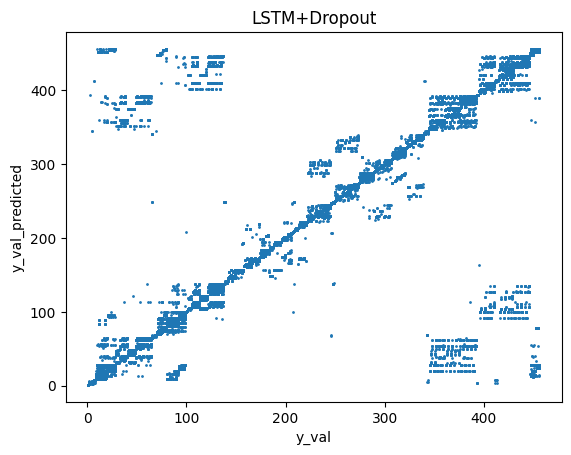

In [55]:
# Plotting the data
plt.scatter(y_val_mech, y_pred_mech, marker='o', s = 1, label='Data Points')

# Adding labels and title
plt.xlabel('y_val')
plt.ylabel('y_val_predicted')
plt.title('LSTM+Dropout')

# # Adding a legend
# plt.legend()

# Display the plot
plt.show()

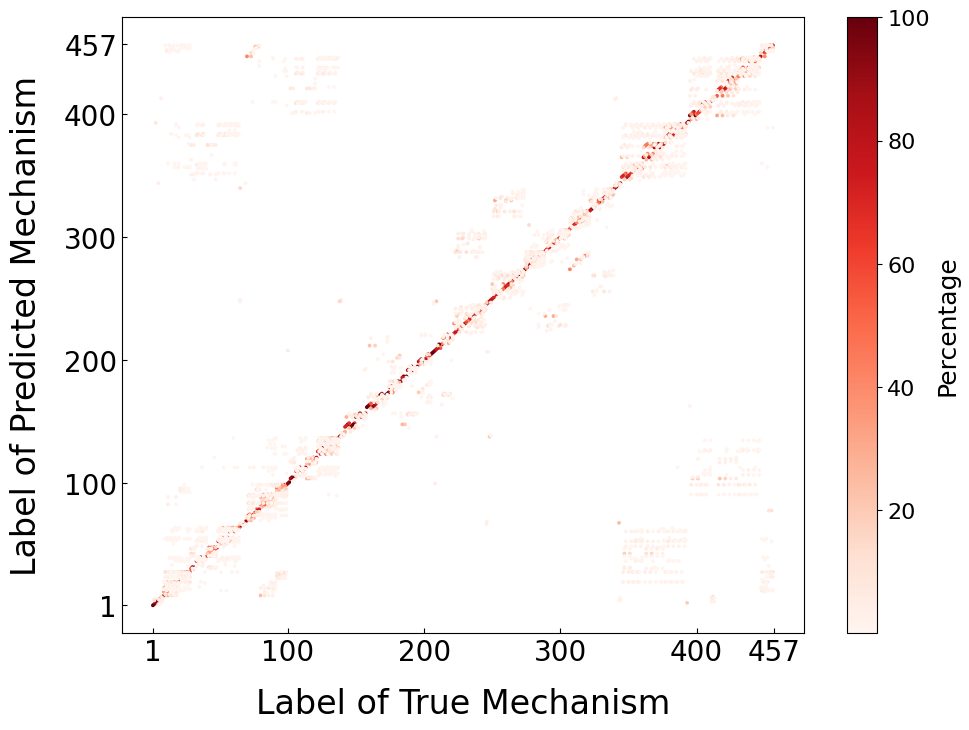

In [56]:
# Calculate the percentage of correct predictions for each unique pair of true and predicted values
count_dict = {} 
for true_val, pred_val in zip(y_val_mech, y_pred_mech):
    if (true_val, pred_val) not in count_dict:
        count_dict[(true_val, pred_val)] = 1
    else:
        count_dict[(true_val, pred_val)] += 1
# print(count_dict)

# Calculate total counts for each value starting from 1 to 456 for key[0]
total_counts = {}
for i in range(1, 457):
    total_counts[i] = sum(value for key, value in count_dict.items() if key[0] == i)
# print(total_counts)


# Calculate percentages
percentages = {}
for key, value in count_dict.items():
    # print(key)
    # print(value)
    percentages[key] = (value / total_counts[key[0]]) * 100
# print(percentages)

# Extract x and y data for the scatter plot
x_data = [key[0] for key in percentages]
y_data = [key[1] for key in percentages]
colors = [value for value in percentages.values()]

plt.figure(figsize=(11, 8))  # Adjust width and height as needed

# Create the scatter plot
# plt.scatter(x_data, y_data, c=colors, cmap='viridis', s = 1)
plt.scatter(x_data, y_data, c=colors, cmap='Reds', s = 3) #, zorder=1)


# Adding labels and title
plt.xlabel('Label of True Mechanism', fontsize = 24, labelpad=15)
plt.ylabel('Label of Predicted Mechanism', fontsize = 24, labelpad=15)
# plt.title('Scatter Plot')

# Add color bar
cbar = plt.colorbar(ticks=[0, 20, 40, 60, 80, 100])
cbar.set_label('Percentage', fontsize=18)  # Adjust the fontsize and labelpad as needed
# Set font size of ticks in color bar
cbar.ax.tick_params(labelsize=16)  # Adjust the font size as needed

# Add axis ticks
plt.xticks([1, 100, 200, 300, 400, 457], fontsize = 20)  # Adjust the range and step size for x-axis ticks
plt.yticks([1, 100, 200, 300, 400, 457], fontsize = 20)  # Adjust the range and step size for x-axis ticks
plt.tick_params(axis='both', direction='in')  # Set ticks to be inside the plot


plt.show()

In [53]:
def calculate_matched_percentage(list1, list2):
    # Ensure that both lists have the same length
    if len(list1) != len(list2):
        raise ValueError("Lists must have the same length")

    # Initialize a counter for matches
    num_matches = 0

    # Iterate over each pair of elements in the lists
    for item1, item2 in zip(list1, list2):
        # Check if the items match
        if item1 == item2:
            num_matches += 1

    # Calculate the percentage of matched values
    matched_percentage = (num_matches / len(list1)) * 100

    return matched_percentage

# Assuming y_pred_mech and y_val_mech are lists containing predicted and true values respectively
matched_percentage = calculate_matched_percentage(y_pred_mech, y_val_mech)
print("Percentage of matched values:", matched_percentage)


Percentage of matched values: 50.45821266032271
